This notebook uses the recently-added support for doing volume rendering of [RAMSES](https://bitbucket.org/rteyssie/ramses/src/master/) datasets using the [yt](yt-project.com) project.

A key ingredient in the formation of disky galaxy in the early stages of the Universe (in its first $\sim 3\mathrm{Gyr}$) is the acquisition of angular momentum that support the rotation of the forming disk.
One important channel uncovered in recent research is through "cold" gas filaments, defined as gas that _never_ heats above $2\times 10^5\mathrm{K}$.
This gas has a peculiar thermal history as well as a peculiar evolution, which could potentially contribute to our understanding of how galaxies spin up.

In this notebook, I am using the output from one of my simulations at $1.75\ \mathrm{Gyr}$ ($z=3.6$) after the Big Bang, focused on one particular galaxy. The simulation has an exquisite resolution of $100 \mathrm{ly}$ ($30 \mathrm{pc}$), so that the galaxy is well-resolved.
In order to find the gas that _never_ heats above $2\times 10^5\mathrm{K}$, I rely on a tracer particle scheme, developed in [Cadiou, _et al._ (2019)](https://www.aanda.org/articles/aa/abs/2019/01/aa34496-18/aa34496-18.html), that allows me to sample the trajectory of the gas as it falls onto the galaxy using particles. For each of them, I check the temperature at all times and keep only those that remained cool the entire way down.
I then project the particles onto the simulation grid to find cells containing cold gas and make a volume rendering out of it.
The tracer particle that track the cold gas have their ids stored in the file `ids_cold_gas.txt`.

# Installing requirements

First install the dependencies. You first need cython, numpy, h5py and (optionally) tqdm.
An important note: this notebook relies on a version of yt that hasn't been integrated in the main, public version as of May 31.
In the meantime, you can use my own fork of yt with the integrated changes by using the cell below.

In [1]:
%%bash
pip install cython numpy tqdm

In [4]:
%%bash

# Clone my version of yt, and install it
mkdir -p tmp && cd tmp/
git clone https://github.com/cphyc/yt.git

Cloning into 'yt'...


In [5]:
%%bash 
cd tmp/yt
git checkout indep-octree-raytracing

Branch 'indep-octree-raytracing' set up to track remote branch 'indep-octree-raytracing' from 'origin'.


Switched to a new branch 'indep-octree-raytracing'


In [6]:
%%bash
cd tmp/yt
# Make sure you have cython and numpy installed *before* issuing this command
pip install -v .

Created temporary directory: /tmp/pip-ephem-wheel-cache-ix6p5wa6
Created temporary directory: /tmp/pip-req-tracker-1b6tsfun
Created requirements tracker '/tmp/pip-req-tracker-1b6tsfun'
Created temporary directory: /tmp/pip-install-us69c2oy
Processing /content/tmp/yt
  Created temporary directory: /tmp/pip-req-build-rsr2iw_v
  Added file:///content/tmp/yt to build tracker '/tmp/pip-req-tracker-1b6tsfun'
    Running setup.py (path:/tmp/pip-req-build-rsr2iw_v/setup.py) egg_info for package from file:///content/tmp/yt
  Source in /tmp/pip-req-build-rsr2iw_v has version 4.0.dev0, which satisfies requirement yt==4.0.dev0 from file:///content/tmp/yt
  Removed yt==4.0.dev0 from file:///content/tmp/yt from build tracker '/tmp/pip-req-tracker-1b6tsfun'
1 location(s) to search for versions of sympy:
* https://pypi.org/simple/sympy/
Getting page https://pypi.org/simple/sympy/
Found index url https://pypi.org/simple
Looking up "https://pypi.org/simple/sympy/" in the cache
Request header has "max_ag

    Running command python setup.py egg_info
    Using OpenMP to compile parallel extensions
    running egg_info
    creating /tmp/pip-req-build-rsr2iw_v/pip-egg-info/yt.egg-info
    writing /tmp/pip-req-build-rsr2iw_v/pip-egg-info/yt.egg-info/PKG-INFO
    writing dependency_links to /tmp/pip-req-build-rsr2iw_v/pip-egg-info/yt.egg-info/dependency_links.txt
    writing entry points to /tmp/pip-req-build-rsr2iw_v/pip-egg-info/yt.egg-info/entry_points.txt
    writing requirements to /tmp/pip-req-build-rsr2iw_v/pip-egg-info/yt.egg-info/requires.txt
    writing top-level names to /tmp/pip-req-build-rsr2iw_v/pip-egg-info/yt.egg-info/top_level.txt
    writing manifest file '/tmp/pip-req-build-rsr2iw_v/pip-egg-info/yt.egg-info/SOURCES.txt'
    Compiling yt/geometry/grid_visitors.pyx because it changed.
    Compiling yt/geometry/grid_container.pyx because it changed.
    Compiling yt/geometry/oct_container.pyx because it changed.
    Compiling yt/geometry/oct_visitors.pyx because it changed.
 

In [0]:
import yt
import numpy as np
from tqdm.auto import tqdm
import numpy as np

# Load the data

In [17]:
%%bash
# Download data into a new folder
# a word of caution here: this will require about 20Gio of space on your hard drive!
mkdir -p data
cd data
[[ ! -e output_00111.tar.gz ]] && wget -O output_00111.tar.gz http://use.yt/upload/a7fb5eee
[[ ! -e output_00111/info_00111.txt ]] && tar xf output_00111.tar.gz

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
%%bash
mkdir -p plots

wget https://raw.githubusercontent.com/cphyc/john_hunter_plotting_contest_2020/master/ids_cold_gas.txt

--2020-06-01 11:46:15--  https://raw.githubusercontent.com/cphyc/john_hunter_plotting_contest_2020/master/ids_cold_gas.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19115959 (18M) [text/plain]
Saving to: ‘ids_cold_gas.txt’

     0K .......... .......... .......... .......... ..........  0% 1.88M 10s
    50K .......... .......... .......... .......... ..........  0% 4.40M 7s
   100K .......... .......... .......... .......... ..........  0% 12.0M 5s
   150K .......... .......... .......... .......... ..........  1% 5.37M 5s
   200K .......... .......... .......... .......... ..........  1% 7.83M 4s
   250K .......... .......... .......... .......... ..........  1% 6.75M 4s
   300K .......... .......... .......... .......... ..........  1% 9.82M 4s
   350K ..

Load the ids of the particle selected and the dataset.

In [0]:
with open('data/output_00111/part_file_descriptor.txt', 'w') as f:
    f.writelines("""# version:  1
# ivar, variable_name, variable_type
  1, position_x, d
  2, position_y, d
  3, position_z, d
  4, velocity_x, d
  5, velocity_y, d
  6, velocity_z, d
  7, mass, d
  8, identity, i
  9, levelp, i
 10, family, b
 11, tag, b
 12, birth_time, d
 13, metallicity, d
 14, partp, i
""")

In [37]:
cold_gas_tracer_ids = np.loadtxt('ids_cold_gas.txt', dtype=int)

# These values are such that the box is centred around one galaxy, with the right boundaries
center, w = np.array([0.50300061, 0.49767861, 0.49692033]), 0.02166748046875
bbox = center-w, center+w

# Load the dataset. The bbox parameter ensures that we're not reading data
# outside the region of interest and speeds things up (and saves a lot of RAM!)
ds = yt.load('data/output_00111/info_00111.txt', bbox=bbox)

yt : [INFO     ] 2020-06-01 12:37:38,764 Parameters: current_time              = 2.5525434507448876
yt : [INFO     ] 2020-06-01 12:37:38,765 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2020-06-01 12:37:38,767 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-06-01 12:37:38,771 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-06-01 12:37:38,773 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-06-01 12:37:38,775 Parameters: current_redshift          = 3.5666829167139156
yt : [INFO     ] 2020-06-01 12:37:38,776 Parameters: omega_lambda              = 0.691100001335144
yt : [INFO     ] 2020-06-01 12:37:38,778 Parameters: omega_matter              = 0.308899998664856
yt : [INFO     ] 2020-06-01 12:37:38,779 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2020-06-01 12:37:38,780 Parameters: hubble_constant           = 0.6773999786376951


Let us use yt to create a particle filter to only retains the cold gas, based on the list of cold gas tracers.
I can then flag cells that contains one of these tracers to easily identify cold flows.

In [38]:
@yt.particle_filter(name='cold_gas', requires=['particle_identity'], filtered_type='all')
def cold_gas(pfilter, data):
    return ((data[(pfilter.filtered_type, 'particle_family')] <= 0) & np.in1d(data[(pfilter.filtered_type, 'particle_identity')].value.astype(int), cold_gas_tracer_ids))

ds.add_particle_filter('cold_gas')
ds.add_deposited_particle_field(('cold_gas', 'particle_mass'), method='cic')

yt : [WARNING  ] 2020-06-01 12:37:43,735 The cold_gas particle filter already exists. Overriding.
yt : [INFO     ] 2020-06-01 12:38:15,036 Adding particle_type: DM
yt : [INFO     ] 2020-06-01 12:38:15,061 Adding particle_type: star
yt : [INFO     ] 2020-06-01 12:38:15,081 Adding particle_type: cloud
yt : [INFO     ] 2020-06-01 12:38:15,102 Adding particle_type: dust
yt : [INFO     ] 2020-06-01 12:38:15,123 Adding particle_type: star_tracer
yt : [INFO     ] 2020-06-01 12:38:15,144 Adding particle_type: cloud_tracer
yt : [INFO     ] 2020-06-01 12:38:15,166 Adding particle_type: dust_tracer
yt : [INFO     ] 2020-06-01 12:38:15,190 Adding particle_type: gas_tracer


('deposit', 'cold_gas_cic_mass')

Now that we have flagged cells that contained at least one tracer particle, we can extract the region containing the cold gas.

In [0]:
sp = ds.box(bbox[0], bbox[1])
reg = sp.cut_region(['obj[("deposit", "cold_gas_cic_mass")] > 0'])

In [0]:
reg['density'].shape

# Temperature

Here we will make 3D volume rendering of the temperature using blue shades.

In [0]:
sc = yt.create_scene(reg, field=('gas', 'temperature'), lens_type='perspective')
source = sc[0]
sc.camera.focus = (sp.center).to('unitary').value
sc.camera.position = bbox[1]
sc.camera.resolution = (2048, 2048)

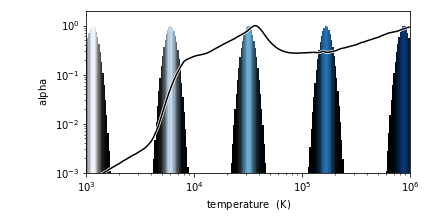

In [26]:
bounds = (1e3, 1e6)

tf = yt.ColorTransferFunction(np.log10(bounds), grey_opacity=True)
tf.add_layers(5, colormap='Blues')
source.tfh.tf = tf
source.tfh.bounds = bounds
source.tfh.log = True

source.tfh.plot(None, profile_field='temperature')

In [27]:
for i, j in tqdm(zip(sc.camera.iter_rotate(np.pi, n_steps=400, rot_center=sp.center),
                     sc.camera.iter_zoom(3, n_steps=400)), total=400):
    sc.save('plots/temperature_%04i.png' % i, sigma_clip=1)

yt : [INFO     ] 2020-06-01 12:29:35,110 Rendering scene (Can take a while).
yt : [INFO     ] 2020-06-01 12:29:35,223 Creating volume
yt : [INFO     ] 2020-06-01 12:32:08,113 Saving render plots/temperature_0000.png
/usr/local/lib/python3.6/dist-packages/yt/data_objects/image_array.py:301: RuntimeWarning: Mean of empty slice.
  nz.mean() + sigma_clip * nz.std())
/usr/local/lib/python3.6/dist-packages/unyt/array.py:1754: RuntimeWarning: invalid value encountered in true_divide
  inp0.view(np.ndarray), inp1.view(np.ndarray), out=out_func, **kwargs
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
yt : [INFO     ] 2020-06-01 12:32:09,947 Rendering scene (Can take a while).
yt : [INFO     ] 2020-06-01 12:32:10,907 Saving render plots/temperature_0001.png
yt : [INFO     ] 2020-06-01 12:32:12,567 Rendering scene (Can take a while).
yt : [INFO     ] 2020-06-01 12:32:13,312 Saving render plots/temperature_0

SystemError: ignored

# Density

Now let's make some plots of the density, this time using the matplotlib's "inferno" colormap (which gives a nice yellowish color to densest regions).

In [0]:
sc = yt.create_scene(reg, field=('gas', 'density'), lens_type='perspective')
source = sc[0]
sc.camera.focus = (sp.center).to('unitary').value
sc.camera.position = bbox[1]
sc.camera.resolution = (2048, 2048)

In [0]:
bounds = (1e-27, 1e-24)

tf = yt.ColorTransferFunction(np.log10(bounds), grey_opacity=False)
tf.add_layers(7, colormap='inferno')
source.tfh.tf = tf
source.tfh.bounds = bounds
source.tfh.log = True

source.tfh.plot(None, profile_field='density')

In [0]:
for i, j in tqdm(zip(sc.camera.iter_rotate(np.pi, n_steps=400, rot_center=sp.center),
                     sc.camera.iter_zoom(3, n_steps=400)), total=400):
    sc.save('plots/density_%04i.png' % i, sigma_clip=2)

# Merge density and temperature layers together

This requires the imagemagick package. When using conda, you can install it using
```bash
conda install -c conda-forge imagemagick
```

In [0]:
%%bash

cd plots/
for ii in {0..399}; do
    i=$(printf "%04d" $ii)
    j=$(python -c "print(int(max(0, (300-int($ii))/3)))")
    echo composite -blend ${j}x100 temperature_$i.png density_$i.png temp_dens_$i.png
    echo convert temp_dens_$i.png -gravity center -crop 1920x1080+0+0 temp_dens_${i}_UHD.png
done | xargs -I{} --max-procs $OMP_NUM_THREADS /bin/sh -c "{}"

Now, let's make a video out of the frames. This requires ffmpeg, which you can also install using
```bash
conda install -c conda-forge ffmpeg openh264
```

In [0]:
%%bash
cd plots
rm temp_dens.mp4
cat temp_dens_????_UHD.png \
    | ffmpeg -f image2pipe -framerate 20 -i - -vcodec libx264 -pix_fmt yuv420p temp_dens_HD.mp4

rm: cannot remove `temp_dens.mp4': No such file or directory
ffmpeg: error while loading shared libraries: libopenh264.so.5: cannot open shared object file: No such file or directory


CalledProcessError: Command 'b'cd plots\nrm temp_dens.mp4\ncat temp_dens_????.png \\\n    | ffmpeg -f image2pipe -framerate 20 -i - -vcodec libx264 -pix_fmt yuv420p temp_dens.mp4\n'' returned non-zero exit status 127.